In [1]:
import dicom
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook
import scipy.misc
from skimage import io
import scipy.stats
import seaborn as sns
import skimage.color
from skimage.filters import threshold_otsu
import keras

from matplotlib import animation
from IPython.display import HTML
from PIL import Image
import pandas as pd
import nibabel as nib
from nibabel.testing import data_path
import dill

Using TensorFlow backend.


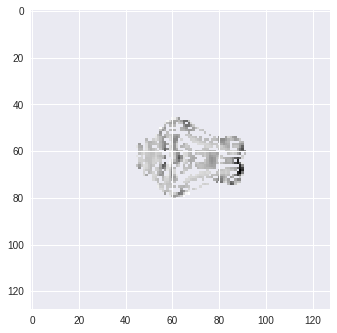

In [2]:
realigned_atlas = nib.load('../Data/big_atlas/coregistered_pig_2_atlas.nii').get_data()
#original_atlas = nib.load('../../Data/big_atlas/atlas.nii').get_data()
anatomical = nib.load('../Data/pig_2/coregistered_anatomy.nii').get_data()
mean_fmri = nib.load('../Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii').get_data()  

mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)
fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), mean_fmri) 
# print(fmri_masked_roi)
plt.imshow(fmri_masked_roi[:,:,10])

In [3]:
# let's try loading the entire thing to ram
# the big tensor will have dimension [time, height, width, depth]

im = mean_fmri
all_data = np.zeros((300, im.shape[0], im.shape[1], im.shape[2]))
masked_data = np.ma.zeros((300, im.shape[0], im.shape[1], im.shape[2]))

dicom_files = [x for x in Path('../Data/pig_2/rfmri nii/').iterdir() if x.is_file() and not 'ds_store' in str(x).lower()]
dicom_files.sort(key=str)
time_index = 0
mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)

for f in tqdm_notebook(dicom_files):
    time_file = nib.load(str(f)).get_data()
    fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), time_file) 
    try:
        masked_data[time_index, ...] = fmri_masked_roi
        all_data[time_index, ...] = time_file
        time_index += 1
    except:
        print(f)

../Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii



In [4]:
assert all_data.shape == (300, 128, 128, 20) #300 time samples, 128x128 image, over 20 slices in z-index
assert masked_data.shape == (300, 128, 128, 20) # basic sanity check

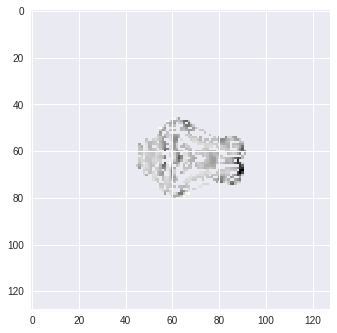

In [5]:
plt.imshow(masked_data[1,:,:,10]) # Mask is generated from an atlas, atlas disregards certain subcortical regions that are just "grey matter"

In [6]:
indices = masked_data[1,:,:,:].nonzero()
df_index = pd.MultiIndex.from_tuples(list(zip(*indices)), names=['row', 'col', 'depth'])
series_df = pd.Series(index=df_index, dtype=object)

for i, triple in tqdm_notebook(enumerate(zip(*indices)), total=len(indices[0])):
    x, y, z = triple
    trace = all_data[:, x, y, z]
    
    series_df.loc[triple] = trace

data_block = np.vstack(series_df.values)[..., np.newaxis]



In [31]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import quniform, uniform
from keras.callbacks import LearningRateScheduler

import math

def data():
    realigned_atlas = nib.load('../Data/big_atlas/coregistered_pig_2_atlas.nii').get_data()
    mean_fmri = nib.load('../Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii').get_data()  

    mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)
    fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), mean_fmri)
    
    im = mean_fmri
    all_data = np.zeros((300, im.shape[0], im.shape[1], im.shape[2]))
    masked_data = np.ma.zeros((300, im.shape[0], im.shape[1], im.shape[2]))

    dicom_files = [x for x in Path('../Data/pig_2/rfmri nii/').iterdir() if x.is_file() and not 'ds_store' in str(x).lower()]
    dicom_files.sort(key=str)
    time_index = 0
    mask_roi_1 = np.ma.masked_where(np.isin(realigned_atlas, [0]), realigned_atlas)

    for f in dicom_files:
        time_file = nib.load(str(f)).get_data()
        fmri_masked_roi = np.ma.masked_where(np.ma.getmask(mask_roi_1), time_file) 
        try:
            masked_data[time_index, ...] = fmri_masked_roi
            all_data[time_index, ...] = time_file
            time_index += 1
        except:
            print(f)
    
    
    indices = masked_data[1,:,:,:].nonzero()
    df_index = pd.MultiIndex.from_tuples(list(zip(*indices)), names=['row', 'col', 'depth'])
    series_df = pd.Series(index=df_index, dtype=object)

    for i, triple in enumerate(zip(*indices)):
        x, y, z = triple
        trace = all_data[:, x, y, z]

        series_df.loc[triple] = trace
    data_block = np.vstack(series_df.values)[..., np.newaxis]
    
    shuffled_data = np.copy(data_block)
    np.random.shuffle(shuffled_data)

    testing_set = shuffled_data[:700]  #hold back 700 for validation
    training_set = shuffled_data[700:]
    
    train_mean = training_set.mean(axis=0)
    train_std = training_set.std(axis=0)
    
    x_train = y_train = training_set
    x_test = y_test = testing_set
    
    return x_train, y_train, x_test, y_test
    
    

def model(x_train, y_train, x_test, y_test):
    from keras.layers.convolutional import Conv1D, UpSampling1D
    from keras.layers.pooling import MaxPooling1D
    from keras.layers.core import Dense, Activation
    from keras.layers.normalization import BatchNormalization
    
    model = keras.models.Sequential()
    
    c1_size = int({{quniform(50, 70, 1)}})
    c1_length = int({{quniform(3, 10, 2)}})
    
    c2_size = int({{quniform(20, 40, 1)}})
    c2_length = int({{quniform(3, 10, 2)}})
    
    c3_size = int({{quniform(10, 30, 1)}})
    c3_length = int({{quniform(3, 10, 2)}})
    
    c4_size = int({{quniform(3, 8, 1)}})
    c4_length = int({{quniform(3, 10, 2)}})
      
    # encoder
    model.add(Conv1D(c1_size, c1_length, 
                     padding='causal', input_shape=[300, 1])) #Dimensionality 300
    model.add(BatchNormalization(momentum={{uniform(0, 1)}}))
    model.add(Activation('relu'))

    model.add(Conv1D(c2_size, c2_length, 
                     padding='causal'))
    model.add(BatchNormalization(momentum={{uniform(0, 1)}}))
    model.add(Activation('relu'))
    model.add(MaxPooling1D())
    
    model.add(Conv1D(c3_size, c3_length, 
                     padding='causal')) # Activation map size [150 x 1]
    model.add(BatchNormalization(momentum={{uniform(0, 1)}}))
    model.add(Activation('relu'))
    model.add(MaxPooling1D())
    
    model.add(Conv1D(c4_size, c4_length, 
                     padding='causal')) # Activation map size [75 x 1]
    model.add(BatchNormalization(momentum={{uniform(0, 1)}}))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3))
    
    # Activation map size [25 x 1] 
    # Encoding represenation size is [25 x 1 x N (8)] = 200
    # Dimensionality reduction of 300 -> 200
    
    # decoder
    model.add(Conv1D(c4_size, c4_length, 
                     padding='causal'))
    model.add(BatchNormalization(momentum={{uniform(0, 1)}}))
    model.add(Activation('relu'))
    model.add(UpSampling1D(size=3))
    
    model.add(Conv1D(c3_size, c3_length, 
                     padding='causal'))
    model.add(BatchNormalization(momentum={{uniform(0, 1)}}))
    model.add(Activation('relu'))
    model.add(UpSampling1D())
    
    model.add(Conv1D(c2_size, c2_length, 
                     padding='causal'))
    model.add(BatchNormalization(momentum={{uniform(0, 1)}}))
    model.add(Activation('relu'))
    model.add(UpSampling1D())
    
    model.add(Conv1D(c1_size, c1_length, 
                     padding='causal'))
    model.add(BatchNormalization(momentum={{uniform(0, 1)}}))
    model.add(Activation('relu'))
    
    model.add(Conv1D(1, 1, padding='causal'))
    model.add(Activation('linear'))
    
    # section 2.1 mentions a special regularization, but I don't think that is going to work
    # the feature map in the compressed representation and the output will not be timeshuffled if we use causal conv
    
    # learning rate schedule
    def step_decay(epoch):
        initial_lrate = 0.01
        drop = 0.5
        epochs_drop = {{quniform(4, 10, 1)}}
        lrate = initial_lrate * drop**(np.floor((1+epoch)/epochs_drop))
        return lrate
    
    kicker = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10, 
                                               verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
    lrate = LearningRateScheduler(step_decay)
    callbacks_list = [keras.callbacks.TerminateOnNaN(), kicker, lrate]
    
    model.compile(optimizer='sgd', loss='mse')
    model.fit(x_train, y_train, epochs=10, batch_size={{choice([32, 64, 128, 256])}}, 
              callbacks=callbacks_list, validation_data=(x_test, x_test), verbose=2)
    
    loss = model.evaluate(x_test, x_test)
    
    if np.isnan(loss):
        loss = float('inf')
        
    
    return {'loss': loss, 'status': STATUS_OK, 'model': model}

    

In [33]:
from hyperopt.mongoexp import MongoTrials

# getting this thing to work with mongotrials is NonTrivial, but also NonImpossible
# trials = MongoTrials('mongo://localhost:1234/foo_db/jobs', exp_key='exp1')

best_run, best_model = optim.minimize(model=model, data=data, algo=tpe.suggest, 
                                      max_evals=200, trials=Trials(),
                                     notebook_name='Experiment 11 - hyperopt', verbose=True)
    

>>> Imports:
#coding=utf-8

try:
    import dicom
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from pathlib import Path
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    from tqdm import tqdm_notebook
except:
    pass

try:
    import scipy.misc
except:
    pass

try:
    from skimage import io
except:
    pass

try:
    import scipy.stats
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    import skimage.color
except:
    pass

try:
    from skimage.filters import threshold_otsu
except:
    pass

try:
    import keras
except:
    pass

try:
    from matplotlib import animation
except:
    pass

try:
    from IPython.display import HTML
except:
    pass

try:
    from PIL import Image
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import nibabel as nib
except:
    pass

try:
    from nibabel.testing import data_path
except

../Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii
Train on 6455 samples, validate on 700 samples
Epoch 1/10
Batch 3: Invalid loss, terminating training
700/700 [==============================] - 1s     
Train on 6455 samples, validate on 700 samples
Epoch 1/10
14s - loss: 3292738.1945 - val_loss: 3131456.4829
Epoch 2/10
12s - loss: 2977899.8273 - val_loss: 2828838.9743
Epoch 3/10
12s - loss: 2534745.1534 - val_loss: 2358108.6600
Epoch 4/10
12s - loss: 2012219.3414 - val_loss: 1651484.6679
Epoch 5/10
12s - loss: 1456771.3749 - val_loss: 1244108.1329
Epoch 6/10
12s - loss: 934210.5935 - val_loss: 662712.8375
Epoch 7/10
12s - loss: 499818.7011 - val_loss: 474341.4591
Epoch 8/10
12s - loss: 199112.5046 - val_loss: 144930.9792
Epoch 9/10
12s - loss: 69700.5327 - val_loss: 65630.2587
Epoch 10/10
12s - loss: 32617.3276 - val_loss: 37119.7315
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
16s - loss: 2606977.3108 - val_loss:

11s - loss: 3166315.4309 - val_loss: 3075466.2500
Epoch 4/10
10s - loss: 2949406.5837 - val_loss: 2868041.9386
Epoch 5/10
11s - loss: 2666530.9245 - val_loss: 2457380.6957
Epoch 6/10
11s - loss: 2333600.6076 - val_loss: 2121598.0100
Epoch 7/10
11s - loss: 1979080.0224 - val_loss: 1945498.7493
Epoch 8/10
10s - loss: 1616928.8004 - val_loss: 1705745.6107
Epoch 9/10
10s - loss: 1271732.6975 - val_loss: 973592.5007
Epoch 10/10
11s - loss: 1029174.9198 - val_loss: 1026052.1100
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
14s - loss: 2699536.0904 - val_loss: 1170188.9357
Epoch 2/10
11s - loss: 576817.2720 - val_loss: 81200.5854
Epoch 3/10
11s - loss: 56109.7217 - val_loss: 21802.3389
Epoch 4/10
11s - loss: 26572.7797 - val_loss: 38702.3243
Epoch 5/10
11s - loss: 24375.9122 - val_loss: 23461.6884
Epoch 6/10
11s - loss: 21740.2051 - val_loss: 85879.7826
Epoch 7/10
11s - loss: 20877.2900 - val_loss: 52315.1088
Epoch 8/10
11s - loss:

Epoch 1/10
Batch 3: Invalid loss, terminating training
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
18s - loss: 3187913.0722 - val_loss: 2649392.5686
Epoch 2/10
15s - loss: 2080270.2685 - val_loss: 1325798.3493
Epoch 3/10
15s - loss: 778195.7760 - val_loss: 426905.6616
Epoch 4/10
15s - loss: 173913.9397 - val_loss: 76297.7401
Epoch 5/10
15s - loss: 49557.5255 - val_loss: 18809.6836
Epoch 6/10
15s - loss: 25333.3760 - val_loss: 11530.0178
Epoch 7/10
15s - loss: 31368.7608 - val_loss: 35296.1232
Epoch 8/10
15s - loss: 22190.2150 - val_loss: 10397.8533
Epoch 9/10
15s - loss: 19800.9372 - val_loss: 10385.7855
Epoch 10/10
15s - loss: 21201.6223 - val_loss: 24169.0312
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
Batch 2: Invalid loss, terminating training
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
16s - 

700/700 [==============================] - 2s     
Train on 6455 samples, validate on 700 samples
Epoch 1/10
20s - loss: 2620552.3562 - val_loss: 1294748.8307
Epoch 2/10
16s - loss: 466205.4881 - val_loss: 51983.1269
Epoch 3/10
16s - loss: 49218.2874 - val_loss: 13086.7698
Epoch 4/10
16s - loss: 30075.4146 - val_loss: 20105.0836
Epoch 5/10
16s - loss: 24265.3051 - val_loss: 13398.7496
Epoch 6/10
16s - loss: 19481.5481 - val_loss: 19219.7245
Epoch 7/10
16s - loss: 21903.5075 - val_loss: 23188.7932
Epoch 8/10
16s - loss: 21234.2865 - val_loss: 9104.7182
Epoch 9/10
16s - loss: 18675.2725 - val_loss: 8061.5382
Epoch 10/10
16s - loss: 17203.9590 - val_loss: 12543.2091
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
18s - loss: 3358353.0604 - val_loss: 3224969.7843
Epoch 2/10
14s - loss: 3242284.7955 - val_loss: 3044823.6829
Epoch 3/10
14s - loss: 3091070.4028 - val_loss: 2827495.3329
Epoch 4/10
14s - loss: 2908902.4727 - val_loss: 

15s - loss: 23994.7800 - val_loss: 4232.3189
Epoch 7/10
15s - loss: 24127.6060 - val_loss: 7854.1795
Epoch 8/10
15s - loss: 20056.1316 - val_loss: 14093.5982
Epoch 9/10
15s - loss: 20036.1660 - val_loss: 11017.1676
Epoch 10/10
15s - loss: 19918.8946 - val_loss: 4780.7405
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
16s - loss: 3194635.0841 - val_loss: 2367309.4000
Epoch 2/10
11s - loss: 2508438.8298 - val_loss: 2330667.3829
Epoch 3/10
11s - loss: 1583398.5327 - val_loss: 1116158.8636
Epoch 4/10
11s - loss: 700946.0285 - val_loss: 670242.1018
Epoch 5/10
11s - loss: 170071.0526 - val_loss: 655971.9154
Epoch 6/10
11s - loss: 34967.2477 - val_loss: 83343.4346
Epoch 7/10
11s - loss: 29322.5350 - val_loss: 133125.9131
Epoch 8/10
11s - loss: 24124.3054 - val_loss: 154559.8996
Epoch 9/10
11s - loss: 17126.0763 - val_loss: 77105.4847
Epoch 10/10
11s - loss: 19474.4372 - val_loss: 115471.0954
672/700 [===========================>..] 

17s - loss: 21490.1798 - val_loss: 17806.8030
Epoch 8/10
17s - loss: 18092.6769 - val_loss: 7285.9870
Epoch 9/10
17s - loss: 19606.2263 - val_loss: 10833.9624
Epoch 10/10
17s - loss: 15854.6406 - val_loss: 10970.4484
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
21s - loss: 2623232.9273 - val_loss: 1137423.8986
Epoch 2/10
16s - loss: 470554.2662 - val_loss: 40171.1110
Epoch 3/10
16s - loss: 37073.6082 - val_loss: 30696.0988
Epoch 4/10
16s - loss: 23334.0080 - val_loss: 17167.9625
Epoch 5/10
16s - loss: 21144.9838 - val_loss: 21142.6653
Epoch 6/10
16s - loss: 20866.3366 - val_loss: 16631.6875
Epoch 7/10
16s - loss: 19262.1441 - val_loss: 5380.2884
Epoch 8/10
16s - loss: 18832.5358 - val_loss: 15548.6065
Epoch 9/10
16s - loss: 16247.7826 - val_loss: 13700.1630
Epoch 10/10
16s - loss: 18015.3408 - val_loss: 51419.9630
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
21s

13s - loss: 1649080.1999 - val_loss: 1058534.1693
Epoch 5/10
13s - loss: 952160.5226 - val_loss: 717499.9525
Epoch 6/10
13s - loss: 442433.9990 - val_loss: 245789.9177
Epoch 7/10
13s - loss: 206496.9640 - val_loss: 98698.7526
Epoch 8/10
13s - loss: 119383.7493 - val_loss: 66180.8600
Epoch 9/10
13s - loss: 68915.1879 - val_loss: 45824.1681
Epoch 10/10
13s - loss: 38743.9671 - val_loss: 39481.4830
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
19s - loss: 3375345.1447 - val_loss: 3332781.4400
Epoch 2/10
13s - loss: 3285215.2818 - val_loss: 3223917.7286
Epoch 3/10
13s - loss: 3116281.1093 - val_loss: 3093775.7500
Epoch 4/10
13s - loss: 2861934.8184 - val_loss: 2714782.5429
Epoch 5/10
13s - loss: 2533015.5027 - val_loss: 2373866.9843
Epoch 6/10
13s - loss: 2151261.0558 - val_loss: 1939278.0679
Epoch 7/10
13s - loss: 1752087.6531 - val_loss: 1484834.2921
Epoch 8/10
13s - loss: 1450905.4071 - val_loss: 1265266.3257
Epoch 9/10
13s -

672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
20s - loss: 3187336.8723 - val_loss: 2756562.4286
Epoch 2/10
13s - loss: 2078744.1632 - val_loss: 1163353.1936
Epoch 3/10
13s - loss: 778762.6261 - val_loss: 342768.4489
Epoch 4/10
13s - loss: 187724.8311 - val_loss: 74360.5652
Epoch 5/10
13s - loss: 51730.9199 - val_loss: 35972.3662
Epoch 6/10
13s - loss: 28407.5237 - val_loss: 8371.3912
Epoch 7/10
13s - loss: 17784.7205 - val_loss: 38771.6677
Epoch 8/10
13s - loss: 16738.9330 - val_loss: 32575.1100
Epoch 9/10
13s - loss: 15101.1616 - val_loss: 6845.7099
Epoch 10/10
13s - loss: 14314.4319 - val_loss: 7027.9904
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
Batch 4: Invalid loss, terminating training
700/700 [==============================] - 3s     
Train on 6455 samples, validate on 700 samples
Epoch 1/10
20s - loss: 3179291.8773 - val_loss: 2628161.9614
Epoch 2/10
14

15s - loss: 17422.1938 - val_loss: 10832.1555
Epoch 9/10
15s - loss: 19289.0975 - val_loss: 11723.5858
Epoch 10/10
15s - loss: 17061.2428 - val_loss: 9583.4210
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
20s - loss: 3187921.7253 - val_loss: 2953070.8657
Epoch 2/10
13s - loss: 2490923.3252 - val_loss: 1998427.8250
Epoch 3/10
12s - loss: 1555743.2991 - val_loss: 872584.2711
Epoch 4/10
12s - loss: 672692.4900 - val_loss: 351725.0118
Epoch 5/10
12s - loss: 154824.3545 - val_loss: 72169.5400
Epoch 6/10
12s - loss: 33394.7630 - val_loss: 36534.2930
Epoch 7/10
12s - loss: 24070.5418 - val_loss: 83632.3847
Epoch 8/10
12s - loss: 26234.8423 - val_loss: 9435.5499
Epoch 9/10
12s - loss: 16231.1979 - val_loss: 24190.9214
Epoch 10/10
12s - loss: 25747.0792 - val_loss: 20774.2624
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
19s - loss: 3157112.0739 - val_loss: 2955775.6300
E

13s - loss: 19700.1207 - val_loss: 14094.5392
Epoch 10/10
13s - loss: 16529.2359 - val_loss: 9197.7215
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
19s - loss: 3379009.8501 - val_loss: 3356783.6571
Epoch 2/10
11s - loss: 3311007.9804 - val_loss: 3276841.5057
Epoch 3/10
11s - loss: 3178031.8359 - val_loss: 3091772.7986
Epoch 4/10
11s - loss: 2974362.0292 - val_loss: 2836316.6486
Epoch 5/10
11s - loss: 2687857.3029 - val_loss: 2436976.1514
Epoch 6/10
11s - loss: 2337471.6414 - val_loss: 2119522.6329
Epoch 7/10
11s - loss: 1969038.5548 - val_loss: 1751506.0564
Epoch 8/10
11s - loss: 1597502.3639 - val_loss: 1436139.5150
Epoch 9/10
11s - loss: 1324242.7490 - val_loss: 1111291.7864
Epoch 10/10
11s - loss: 1162581.4484 - val_loss: 1084304.2379
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
21s - loss: 3220209.9500 - val_loss: 2880250.4257
Epoch 2/10
13s - loss: 2232954.

15s - loss: 731020.3551 - val_loss: 449295.0161
Epoch 4/10
15s - loss: 159097.8016 - val_loss: 84406.7153
Epoch 5/10
15s - loss: 43311.0592 - val_loss: 24628.0592
Epoch 6/10
15s - loss: 30594.8148 - val_loss: 71349.4063
Epoch 7/10
15s - loss: 23588.5313 - val_loss: 8805.4137
Epoch 8/10
15s - loss: 21075.0148 - val_loss: 26163.2172
Epoch 9/10
15s - loss: 21162.8441 - val_loss: 7083.5876
Epoch 10/10
15s - loss: 15393.2112 - val_loss: 9299.8276
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
22s - loss: 3176583.0454 - val_loss: 2834726.7671
Epoch 2/10
14s - loss: 2449359.0880 - val_loss: 2262221.0300
Epoch 3/10
14s - loss: 1483177.9122 - val_loss: 668908.3611
Epoch 4/10
13s - loss: 600207.4213 - val_loss: 34217.7876
Epoch 5/10
13s - loss: 119497.4439 - val_loss: 68535.4203
Epoch 6/10
13s - loss: 45106.8583 - val_loss: 32634.4908
Epoch 7/10
13s - loss: 26735.8027 - val_loss: 15621.0992
Epoch 8/10
13s - loss: 15141.5603 - val_loss:

16s - loss: 2171218.3617 - val_loss: 925443.7829
Epoch 3/10
16s - loss: 885127.5542 - val_loss: 367601.2327
Epoch 4/10
15s - loss: 219858.1570 - val_loss: 28504.7340
Epoch 5/10
15s - loss: 55562.9766 - val_loss: 35673.9121
Epoch 6/10
15s - loss: 29431.2044 - val_loss: 38933.3381
Epoch 7/10
15s - loss: 21554.6425 - val_loss: 9368.1388
Epoch 8/10
15s - loss: 21043.1219 - val_loss: 12354.2271
Epoch 9/10
15s - loss: 19202.5027 - val_loss: 44004.7210
Epoch 10/10
15s - loss: 17881.3817 - val_loss: 14173.7933
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
24s - loss: 3217102.3835 - val_loss: 2891398.6314
Epoch 2/10
14s - loss: 2236191.4613 - val_loss: 1562549.0286
Epoch 3/10
14s - loss: 969053.4618 - val_loss: 351537.1200
Epoch 4/10
14s - loss: 265124.8674 - val_loss: 166958.9488
Epoch 5/10
14s - loss: 61969.9313 - val_loss: 22815.7956
Epoch 6/10
14s - loss: 27142.6460 - val_loss: 28726.4248
Epoch 7/10
14s - loss: 23438.5474 - val_l

Epoch 1/10
22s - loss: 3378917.2141 - val_loss: 3365828.5471
Epoch 2/10
12s - loss: 3299520.7385 - val_loss: 3065146.6900
Epoch 3/10
11s - loss: 3142441.7718 - val_loss: 2265372.3786
Epoch 4/10
11s - loss: 2905638.5435 - val_loss: 1638564.9336
Epoch 5/10
11s - loss: 2598071.1278 - val_loss: 2321763.8686
Epoch 6/10
11s - loss: 2236508.2270 - val_loss: 898964.4296
Epoch 7/10
11s - loss: 1852777.0409 - val_loss: 921242.0296
Epoch 8/10
11s - loss: 1470321.0016 - val_loss: 1005945.2643
Epoch 9/10
11s - loss: 1198060.5710 - val_loss: 417167.9666
Epoch 10/10
11s - loss: 1036522.3640 - val_loss: 2358215.4971
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
25s - loss: 3200410.1399 - val_loss: 3180430.5743
Epoch 2/10
15s - loss: 2542557.9325 - val_loss: 2262368.1700
Epoch 3/10
15s - loss: 1642580.3900 - val_loss: 452643.5811
Epoch 4/10
15s - loss: 761007.2537 - val_loss: 211190.2363
Epoch 5/10
15s - loss: 199216.8502 - val_loss: 140959.

13s - loss: 344432.8493 - val_loss: 165858.2274
Epoch 8/10
13s - loss: 158870.2727 - val_loss: 46070.4742
Epoch 9/10
13s - loss: 85876.8015 - val_loss: 104614.2019
Epoch 10/10
13s - loss: 58695.7857 - val_loss: 33366.3674
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
26s - loss: 2719924.0581 - val_loss: 1491752.1136
Epoch 2/10
15s - loss: 790713.5502 - val_loss: 67257.2836
Epoch 3/10
15s - loss: 39639.9622 - val_loss: 22718.3219
Epoch 4/10
15s - loss: 21989.1518 - val_loss: 44459.5346
Epoch 5/10
15s - loss: 20206.7206 - val_loss: 16252.3176
Epoch 6/10
15s - loss: 15905.9583 - val_loss: 102661.1949
Epoch 7/10
15s - loss: 13935.7854 - val_loss: 16356.9838
Epoch 8/10
15s - loss: 13216.6169 - val_loss: 26757.2081
Epoch 9/10
15s - loss: 13473.1105 - val_loss: 96097.0021
Epoch 10/10
15s - loss: 14145.7318 - val_loss: 16013.1244
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1

14s - loss: 2056086.7733 - val_loss: 1333776.8800
Epoch 3/10
14s - loss: 745075.5194 - val_loss: 204660.0410
Epoch 4/10
14s - loss: 165734.8725 - val_loss: 45897.0903
Epoch 5/10
14s - loss: 49032.2026 - val_loss: 119543.3687
Epoch 6/10
14s - loss: 45620.1129 - val_loss: 22599.9103
Epoch 7/10
14s - loss: 21971.8456 - val_loss: 6911.5947
Epoch 8/10
14s - loss: 22569.3734 - val_loss: 12182.7765
Epoch 9/10
14s - loss: 17929.5202 - val_loss: 6412.5319
Epoch 10/10
14s - loss: 16354.6030 - val_loss: 7597.7434
672/700 [===========================>..] - ETA: 0sTrain on 6455 samples, validate on 700 samples
Epoch 1/10
26s - loss: 3177015.1089 - val_loss: 3149489.3386
Epoch 2/10
15s - loss: 2447800.1009 - val_loss: 2134608.4293
Epoch 3/10
15s - loss: 1481219.8722 - val_loss: 834753.2782
Epoch 4/10
15s - loss: 601121.3772 - val_loss: 85500.8101
Epoch 5/10
15s - loss: 129115.1849 - val_loss: 13453.3489
Epoch 6/10
15s - loss: 25908.5987 - val_loss: 16725.5315
Epoch 7/10
15s - loss: 23506.4318 - val_

In [35]:
# SGD only run
best_run

{'batch_size': 1,
 'epochs_drop': 6.0,
 'int': 70.0,
 'int_1': 10.0,
 'int_2': 29.0,
 'int_3': 6.0,
 'int_4': 26.0,
 'int_5': 4.0,
 'int_6': 6.0,
 'int_7': 10.0,
 'momentum': 0.5186423556977744,
 'momentum_1': 0.31254252779706654,
 'momentum_2': 0.9049779994209975,
 'momentum_3': 0.7076337169244482,
 'momentum_4': 0.4902576186533732,
 'momentum_5': 0.3635381162393651,
 'momentum_6': 0.10832276204877182,
 'momentum_7': 0.7064914253373168,
 'optimizer': 1}

In [28]:
# generic run after starting momentum optimization
{'batch_size': 0,
 'epochs_drop': 6.0,
 'int': 66.0,
 'int_1': 14.0,
 'int_2': 21.0,
 'int_3': 8.0,
 'int_4': 26.0,
 'int_5': 4.0,
 'int_6': 8.0,
 'int_7': 12.0,
 'momentum': 0.7625581594987776,
 'momentum_1': 0.6915346866101036,
 'momentum_2': 0.8669576617790834,
 'momentum_3': 0.9718592294411714,
 'momentum_4': 0.14514364721165218,
 'momentum_5': 0.47268542196596874,
 'momentum_6': 0.7275581656084844,
 'momentum_7': 0.7628124303271064,
 'optimizer': 1}

{'batch_size': 0,
 'epochs_drop': 6.0,
 'int': 66.0,
 'int_1': 14.0,
 'int_2': 21.0,
 'int_3': 8.0,
 'int_4': 26.0,
 'int_5': 4.0,
 'int_6': 8.0,
 'int_7': 12.0,
 'momentum': 0.7625581594987776,
 'momentum_1': 0.6915346866101036,
 'momentum_2': 0.8669576617790834,
 'momentum_3': 0.9718592294411714,
 'momentum_4': 0.14514364721165218,
 'momentum_5': 0.47268542196596874,
 'momentum_6': 0.7275581656084844,
 'momentum_7': 0.7628124303271064,
 'optimizer': 1}

In [ ]:
# weird best run after the whitening
{'batch': 64,
'epochs to drop': 6,
'c1_num': 66,
'c1_len': 12,
'c2_num': 35,
'c2_len': 4,
'c3_num': 10,
'c3_len': 6,
'c4_num': 5,
'c4_len': 4,
'opt': 'rmsprop'}

In [36]:
x_train, y_train, x_test, y_test = data()

best_model.evaluate(x_test, x_test)

../Data/pig_2/rfmri nii/meanus822-0016-00001-000001-01.nii
672/700 [===========================>..] - ETA: 0s

3866.3554938616071

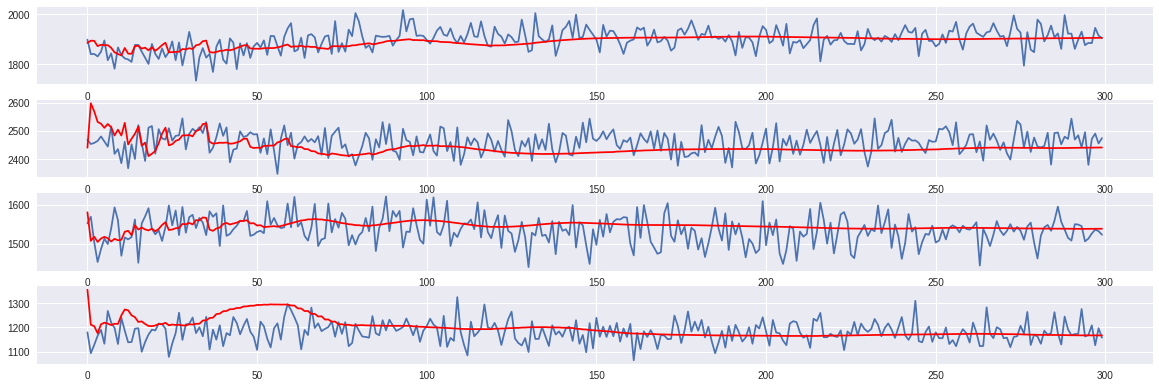

In [37]:
from keras import backend as K
from keras.models import load_model


# sample_1 = data_block[np.newaxis, 1000]
sample_1 = x_test[np.newaxis, 688]
output_1 = best_model.predict(sample_1)

# sample_2 = data_block[np.newaxis, 10]
sample_2 = x_test[np.newaxis, 33]
output_2 = best_model.predict(sample_2)

# sample_3 = data_block[np.newaxis, 66]
sample_3 = x_test[np.newaxis, 123]
output_3 = best_model.predict(sample_3)

# sample_4 = data_block[np.newaxis, 6000]
sample_4 = x_test[np.newaxis, 98]
output_4 = best_model.predict(sample_4)


plt.figure(figsize=(20, 10))
plt.subplot(611)
plt.plot(np.squeeze(sample_1))
plt.plot(np.squeeze(output_1), c='r')
plt.subplot(612)
plt.plot(np.squeeze(sample_2))
plt.plot(np.squeeze(output_2), c='r')
plt.subplot(613)
plt.plot(np.squeeze(sample_3))
plt.plot(np.squeeze(output_3), c='r')
plt.subplot(614)
plt.plot(np.squeeze(sample_4))
plt.plot(np.squeeze(output_4), c='r')


In [ ]:
# DO NOT SUBTRACT MEAN + WHITEN. big outliers ruin sensitivity to local behavior.